# Population Density of Mexican States and Municipalities

This Notebook downloads Geopandas GeoDataFrames for States (admin1) and Municipalities (admin2) derived from the 2020 Mexican Census: [INEGI](https://www.inegi.org.mx/temas/mg/).

For details how these dataframe were created, see the [mexican-boundaries](https://github.com/sbl-sdsc/mexico-boundaries) GitHub project.

It also uses the variables of dataframe obtain in the [Week 3 analyzes](Week3States.ipynb).

Due the bad clustering generated this part of the project will remain pending until the data that is being used is optimal for the clustering method is better or when a better understanding of clustering is achieve.

In [1]:
from io import BytesIO
from urllib.request import urlopen
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

In [2]:
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns

## Boundaries of Mexican Municipalities

Read boundary polygons for Mexican states from shapefile

In [3]:
admin2_url = 'https://raw.githubusercontent.com/sbl-sdsc/mexico-boundaries/main/data/mexico_admin2.parquet'

In [4]:
resp = urlopen(admin2_url)
admin2 = gpd.read_parquet(BytesIO(resp.read()))

Calculate the area of each state (convert area from m^2 to km^2

In [5]:
admin2.crs

<Projected CRS: PROJCRS["MEXICO_ITRF_2008_LCC",BASEGEOGCRS["MEXICO ...>
Name: MEXICO_ITRF_2008_LCC
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: International Terrestrial Reference Frame 2008
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [6]:
admin2['CVE_MUNI'] = admin2['CVE_ENT'] + admin2['CVE_MUN']

In [7]:
admin2.head()

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,CVE_MUNI
0,01001,01,001,Aguascalientes,"POLYGON ((2489072.503 1115771.584, 2489352.774...",01001
1,01002,01,002,Asientos,"POLYGON ((2494680.261 1141224.505, 2494749.948...",01002
2,01003,01,003,Calvillo,"POLYGON ((2429607.454 1120262.254, 2429071.902...",01003
3,01004,01,004,Cosío,"POLYGON ((2470517.824 1155028.588, 2470552.248...",01004
4,01005,01,005,Jesús María,"POLYGON ((2465526.729 1114740.466, 2465752.546...",01005


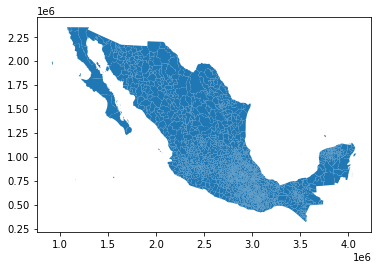

In [8]:
admin2.plot();

## Map of Population by Municipality

Get week 3 analyzes data files

In [9]:
var_admin2 = pd.read_csv('../../data/week3analyzesMunicipalities.csv')

In [10]:
var_admin2.head()

,cve_ent,case_rate,case_rate_last_60_days,death_rate,death_rate_last_60_days,pct_disability,pct_limitation,pct_mental_problem,pct_no_problems,pct_no_med_insurance,pct_med_insurance,pct_pop_obesity,pct_pop_hypertension,pct_pop_diabetes,average_years_finish,average_household_size,pct_household_tics,pct_household_no_tics,population/sqkm
0,1001,2294.857361,70.687761,222.770399,7.484586,4.940347,12.131787,1.449619,80.812119,18.004485,80.497039,31.486541,14.942242,7.495861,10.84,3.54,99.725989,0.274011,824.769043
1,1002,912.236552,29.490406,70.776974,1.966027,5.673954,8.947389,1.360491,85.929144,14.922145,86.351840,32.282284,15.320425,7.953634,8.54,4.10,98.588742,1.411258,93.607672
2,1003,1616.194865,8.229098,42.791310,0.000000,6.728111,11.125741,1.960171,77.080316,19.473338,76.316656,40.004293,13.751906,9.172624,8.05,3.74,99.112312,0.887688,65.803308
3,1004,768.412342,29.554321,70.930370,0.000000,4.758246,11.425700,1.217638,83.733302,13.872798,86.600071,32.596450,16.431493,7.383116,9.08,4.32,98.729997,1.270003,131.777013
4,1005,598.383826,16.131015,47.624900,0.768144,3.868371,9.143981,1.261292,86.048209,20.969551,78.679408,34.731715,12.356755,6.745819,10.22,3.91,99.554405,0.445595,260.422641


Add 5-digit municipality code column (example: convert 5035 -> 05035)

In [11]:
var_admin2['CVE_MUNI'] = var_admin2['cve_ent'].apply(lambda i: f'{i:05d}')

In [12]:
var_admin2.head()

,cve_ent,case_rate,case_rate_last_60_days,death_rate,death_rate_last_60_days,pct_disability,pct_limitation,pct_mental_problem,pct_no_problems,pct_no_med_insurance,pct_med_insurance,pct_pop_obesity,pct_pop_hypertension,pct_pop_diabetes,average_years_finish,average_household_size,pct_household_tics,pct_household_no_tics,population/sqkm,CVE_MUNI
0,1001,2294.857361,70.687761,222.770399,7.484586,4.940347,12.131787,1.449619,80.812119,18.004485,80.497039,31.486541,14.942242,7.495861,10.84,3.54,99.725989,0.274011,824.769043,01001
1,1002,912.236552,29.490406,70.776974,1.966027,5.673954,8.947389,1.360491,85.929144,14.922145,86.351840,32.282284,15.320425,7.953634,8.54,4.10,98.588742,1.411258,93.607672,01002
2,1003,1616.194865,8.229098,42.791310,0.000000,6.728111,11.125741,1.960171,77.080316,19.473338,76.316656,40.004293,13.751906,9.172624,8.05,3.74,99.112312,0.887688,65.803308,01003
3,1004,768.412342,29.554321,70.930370,0.000000,4.758246,11.425700,1.217638,83.733302,13.872798,86.600071,32.596450,16.431493,7.383116,9.08,4.32,98.729997,1.270003,131.777013,01004
4,1005,598.383826,16.131015,47.624900,0.768144,3.868371,9.143981,1.261292,86.048209,20.969551,78.679408,34.731715,12.356755,6.745819,10.22,3.91,99.554405,0.445595,260.422641,01005


Merge the geo dataframe with the population dataframe using the common CVE_MUNI column

In [13]:
df_admin2 = admin2.merge(var_admin2, on='CVE_MUNI')

In [14]:
df_admin2.head()

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,CVE_MUNI,cve_ent,case_rate,case_rate_last_60_days,death_rate,death_rate_last_60_days,pct_disability,pct_limitation,pct_mental_problem,pct_no_problems,pct_no_med_insurance,pct_med_insurance,pct_pop_obesity,pct_pop_hypertension,pct_pop_diabetes,average_years_finish,average_household_size,pct_household_tics,pct_household_no_tics,population/sqkm
0,01001,01,001,Aguascalientes,"POLYGON ((2489072.503 1115771.584, 2489352.774...",01001,1001,2294.857361,70.687761,222.770399,7.484586,4.940347,12.131787,1.449619,80.812119,18.004485,80.497039,31.486541,14.942242,7.495861,10.84,3.54,99.725989,0.274011,824.769043
1,01002,01,002,Asientos,"POLYGON ((2494680.261 1141224.505, 2494749.948...",01002,1002,912.236552,29.490406,70.776974,1.966027,5.673954,8.947389,1.360491,85.929144,14.922145,86.351840,32.282284,15.320425,7.953634,8.54,4.10,98.588742,1.411258,93.607672
2,01003,01,003,Calvillo,"POLYGON ((2429607.454 1120262.254, 2429071.902...",01003,1003,1616.194865,8.229098,42.791310,0.000000,6.728111,11.125741,1.960171,77.080316,19.473338,76.316656,40.004293,13.751906,9.172624,8.05,3.74,99.112312,0.887688,65.803308
3,01004,01,004,Cosío,"POLYGON ((2470517.824 1155028.588, 2470552.248...",01004,1004,768.412342,29.554321,70.930370,0.000000,4.758246,11.425700,1.217638,83.733302,13.872798,86.600071,32.596450,16.431493,7.383116,9.08,4.32,98.729997,1.270003,131.777013
4,01005,01,005,Jesús María,"POLYGON ((2465526.729 1114740.466, 2465752.546...",01005,1005,598.383826,16.131015,47.624900,0.768144,3.868371,9.143981,1.261292,86.048209,20.969551,78.679408,34.731715,12.356755,6.745819,10.22,3.91,99.554405,0.445595,260.422641


The columns that are not needed for this analysis are excluded

In [15]:
a2 = df_admin2.iloc[:,7:].copy()
a2.head()

,case_rate,case_rate_last_60_days,death_rate,death_rate_last_60_days,pct_disability,pct_limitation,pct_mental_problem,pct_no_problems,pct_no_med_insurance,pct_med_insurance,pct_pop_obesity,pct_pop_hypertension,pct_pop_diabetes,average_years_finish,average_household_size,pct_household_tics,pct_household_no_tics,population/sqkm
0,2294.857361,70.687761,222.770399,7.484586,4.940347,12.131787,1.449619,80.812119,18.004485,80.497039,31.486541,14.942242,7.495861,10.84,3.54,99.725989,0.274011,824.769043
1,912.236552,29.490406,70.776974,1.966027,5.673954,8.947389,1.360491,85.929144,14.922145,86.351840,32.282284,15.320425,7.953634,8.54,4.10,98.588742,1.411258,93.607672
2,1616.194865,8.229098,42.791310,0.000000,6.728111,11.125741,1.960171,77.080316,19.473338,76.316656,40.004293,13.751906,9.172624,8.05,3.74,99.112312,0.887688,65.803308
3,768.412342,29.554321,70.930370,0.000000,4.758246,11.425700,1.217638,83.733302,13.872798,86.600071,32.596450,16.431493,7.383116,9.08,4.32,98.729997,1.270003,131.777013
4,598.383826,16.131015,47.624900,0.768144,3.868371,9.143981,1.261292,86.048209,20.969551,78.679408,34.731715,12.356755,6.745819,10.22,3.91,99.554405,0.445595,260.422641


Only the data of interest is selected

In [16]:
a2 = a2[['case_rate', 'death_rate', 'pct_mental_problem', 'pct_no_problems','pct_pop_obesity', 'population/sqkm']].copy()

The data is normalized

In [17]:
#std_scaler = StandardScaler()
std_scaler = RobustScaler()
#std_scaler = MinMaxScaler()
std_scaler
# fit and transform the data
X = pd.DataFrame(std_scaler.fit_transform(a2))

X.head(10)

,0,1,2,3,4,5
0,2.132426,1.375862,0.913028,0.238961,-0.063691,5.879896
1,0.489631,-0.048968,0.689055,0.703505,0.005827,0.283766
2,1.326056,-0.311314,2.196009,-0.099826,0.680440,0.070958
3,0.318743,-0.047531,0.330077,0.504158,0.033273,0.575905
4,0.116720,-0.266003,0.439776,0.714314,0.219815,1.560527
5,1.455212,0.411743,0.067852,-0.036468,-0.712706,1.523689
6,0.842258,0.192948,0.269406,0.249503,-0.041261,0.759306
7,0.881575,-0.033226,0.053423,0.234959,-0.079617,-0.346483
8,0.753618,-0.052959,-0.011647,0.555466,-0.022889,0.325256
9,-0.236952,-0.071753,-0.153513,-0.071209,0.248240,-0.099430


The clustering beggings using the DBSCAN method

In [18]:
# Compute DBSCAN
db = DBSCAN(eps=0.5, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
#with np.printoptions(threshold=np.inf):
#     print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 15
Estimated number of noise points: 1461
Silhouette Coefficient: -0.461


In [19]:
df_labels = pd.DataFrame(labels, columns=['cluster'])

In [20]:
df2 = pd.concat([df_admin2, df_labels], axis=1)

In [21]:
df2.head()

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,CVE_MUNI,cve_ent,case_rate,case_rate_last_60_days,death_rate,death_rate_last_60_days,pct_disability,pct_limitation,pct_mental_problem,pct_no_problems,pct_no_med_insurance,pct_med_insurance,pct_pop_obesity,pct_pop_hypertension,pct_pop_diabetes,average_years_finish,average_household_size,pct_household_tics,pct_household_no_tics,population/sqkm,cluster
0,01001,01,001,Aguascalientes,"POLYGON ((2489072.503 1115771.584, 2489352.774...",01001,1001,2294.857361,70.687761,222.770399,7.484586,4.940347,12.131787,1.449619,80.812119,18.004485,80.497039,31.486541,14.942242,7.495861,10.84,3.54,99.725989,0.274011,824.769043,-1
1,01002,01,002,Asientos,"POLYGON ((2494680.261 1141224.505, 2494749.948...",01002,1002,912.236552,29.490406,70.776974,1.966027,5.673954,8.947389,1.360491,85.929144,14.922145,86.351840,32.282284,15.320425,7.953634,8.54,4.10,98.588742,1.411258,93.607672,0
2,01003,01,003,Calvillo,"POLYGON ((2429607.454 1120262.254, 2429071.902...",01003,1003,1616.194865,8.229098,42.791310,0.000000,6.728111,11.125741,1.960171,77.080316,19.473338,76.316656,40.004293,13.751906,9.172624,8.05,3.74,99.112312,0.887688,65.803308,-1
3,01004,01,004,Cosío,"POLYGON ((2470517.824 1155028.588, 2470552.248...",01004,1004,768.412342,29.554321,70.930370,0.000000,4.758246,11.425700,1.217638,83.733302,13.872798,86.600071,32.596450,16.431493,7.383116,9.08,4.32,98.729997,1.270003,131.777013,0
4,01005,01,005,Jesús María,"POLYGON ((2465526.729 1114740.466, 2465752.546...",01005,1005,598.383826,16.131015,47.624900,0.768144,3.868371,9.143981,1.261292,86.048209,20.969551,78.679408,34.731715,12.356755,6.745819,10.22,3.91,99.554405,0.445595,260.422641,-1


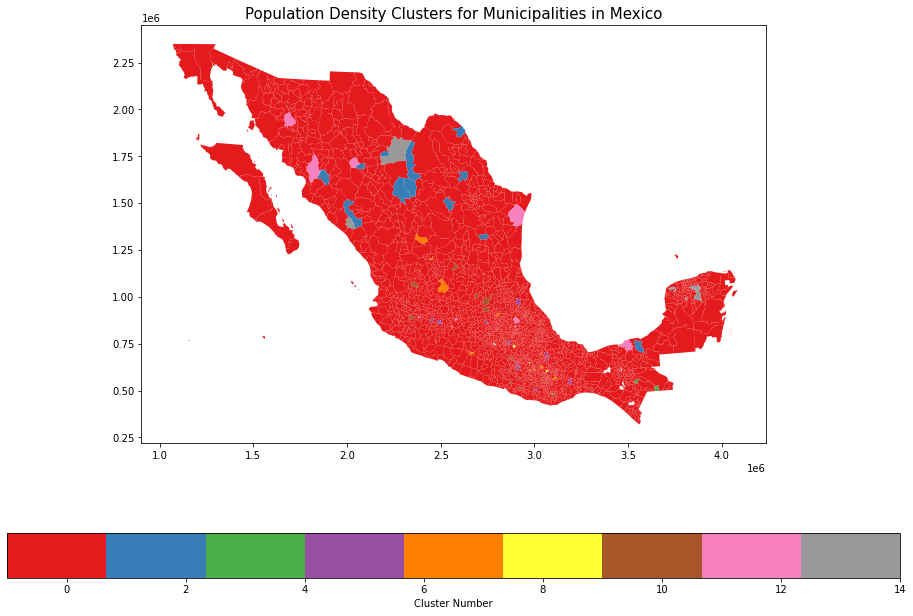

In [22]:
title = 'Population Density Clusters for Municipalities in Mexico'
ax1 = df2.plot(column='cluster', 
#               cmap='OrRd',
# color maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
               cmap='Set1',
               legend=True, 
               legend_kwds={'label': 'Cluster Number', 
                            'orientation': 'horizontal'},
               figsize=(16, 11));
ax1.set_title(title, fontsize=15);

In [23]:
# try Plotly with KDE density plot
# bubble maps (see Ebola example with time series):
# https://plotly.com/python/bubble-maps/